In [1]:
import os
import os.path as osp
import argparse
import copy

import json
import math
import numpy as np
import pandas as pd
from PIL import Image
import imageio as iio
import cv2

from pyntcloud import PyntCloud
from plyfile import PlyData

from utils.json_to_landmark.pyutils import getImageRatio_V2, _kps1d_to_2d, _kps_downscale, get_proj_depth_V2
from utils.json_to_landmark.size_info import getSizingPts

In [2]:
''' hyper-params '''
FX_DEPTH = 5.8262448167737955e+02
FY_DEPTH = 5.8269103270988637e+02
CX_DEPTH = 3.1304475870804731e+02
CY_DEPTH = 2.3844389626620386e+02

In [3]:
root = 'samples/point_cloud_sample1'

In [4]:
print('root :',root)

''' File Load '''
predicted_json_file = osp.join(root, 'estimated_kpt.json')
print('predicted_json_file : ',predicted_json_file)
with open(predicted_json_file, 'r') as f:
    predicted_json = json.load(f)

img_path = f'{root}/rgb.jpg'
depth_path = f'{root}/depth.jpg'
image = Image.open(img_path) 
depth_image = iio.imread(depth_path)
depth_image = depth_image[:,:,0]
print('img_path :',img_path)
print('depth_path :',depth_path)
print('image shape : ',image.size)
print('depth_image shape : ',depth_image.shape) # (192, 256)
''' '''

''' Make new_ply.ply & Load new_ply '''
img_arr = np.asarray(image)
pcd = []
height, width = 192, 256 # (192, 256)
for i in range(height): 
    for j in range(width): 
        z = depth_image[i][j]
        x = (j - CX_DEPTH) * z / FX_DEPTH
        y = (i - CY_DEPTH) * z / FY_DEPTH
        r = img_arr[:,:,0][i][j]
        g = img_arr[:,:,1][i][j]
        b = img_arr[:,:,2][i][j]
        x_coord, y_coord = j,i
        pcd.append([x, y, z, r,g,b, x_coord, y_coord])

pcd = np.array(pcd, dtype=np.float32)
pcd = {'x': pcd[:, 0],
       'y': pcd[:, 1],
       'z': pcd[:, 2],
       'r': pcd[:, 3],
       'g': pcd[:, 4],
       'b': pcd[:, 5],
       'x_coord': pcd[:, 6],
       'y_coord': pcd[:, 7]
        }
# build a cloud
cloud = PyntCloud(pd.DataFrame(pcd))
cloud.to_file(osp.join(root,'new_ply.ply'), as_text=True)

ply = PlyData.read(osp.join(root,'new_ply.ply')) 
assert ply['vertex'].count==49152
''' '''



''' json to Landmark position & length(cm) calculation '''
measure_index, measure_points = getSizingPts(1) # 1: 반팔
w_r, h_r = getImageRatio_V2(image, (192,256))

predicted = predicted_json[0]
pred_kpt1d = predicted['keypoints']
kps_arr = _kps1d_to_2d(pred_kpt1d)
kps_arr = _kps_downscale(kps_arr, (w_r, h_r)) 
kps_dict = {i+1: arr for i, arr in enumerate(kps_arr)}
ply_dpt = get_proj_depth_V2(ply, (192,256)) # projected depth array

result = {name:{'pt1':None, 'pt2':None,'depth_pt1':None,'depth_pt2':None, 'cm':None} for name in measure_index.values()}
for a, name in measure_index.items() : 
    pt1, pt2 = [tuple(kps_dict[pt_key].astype(int)) for pt_key in measure_points[a]]
    result[name]['depth_pt1'] = int(pt1[0]) , int(pt1[1])
    result[name]['depth_pt2'] = int(pt2[0]) , int(pt2[1])
    result[name]['pt1'] = int(pt1[0]*w_r), int(pt1[1]*h_r)
    result[name]['pt2'] = int(pt2[0]*w_r), int(pt2[1]*h_r)

    point_a = ply_dpt[pt1]
    point_b = ply_dpt[pt2]
    size_ = np.linalg.norm(point_a-point_b)
    result[name]['cm'] = float(str(size_)[:5])

root : samples/point_cloud_sample1
predicted_json_file :  samples/point_cloud_sample1/estimated_kpt.json
img_path : samples/point_cloud_sample1/rgb.jpg
depth_path : samples/point_cloud_sample1/depth.jpg
image shape :  (1920, 1440)
depth_image shape :  (192, 256)


/home/kok/anaconda3/envs/hmgit/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if sys.path[0] == "":


In [65]:
img_arr = np.asarray(image)
for r in result : 
    pt1, pt2 = result[r]['pt1'] , result[r]['pt2']
    cm = result[r]['cm']

    for c in [pt1, pt2] :
        cv2.circle(img_arr,
                c,
                5,
                (255,0,0),
                thickness=-1
              )
    cv2.line(img_arr,
        pt1,
        pt2,
        (255,0,0), 
        thickness=2, 
        lineType=cv2.LINE_AA)
    cv2.putText(img_arr, r, (pt2[0]-100,pt2[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    if r == 'Waist-length' :
         cv2.putText(img_arr, f'({cm}cm)', (pt2[0]+110,pt2[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    elif r == 'Total-length' :
        cv2.putText(img_arr, f'({cm}cm)', (pt2[0]+100,pt2[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    else :
        cv2.putText(img_arr, f'({cm}cm)', (pt2[0]-100,pt2[1]+80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

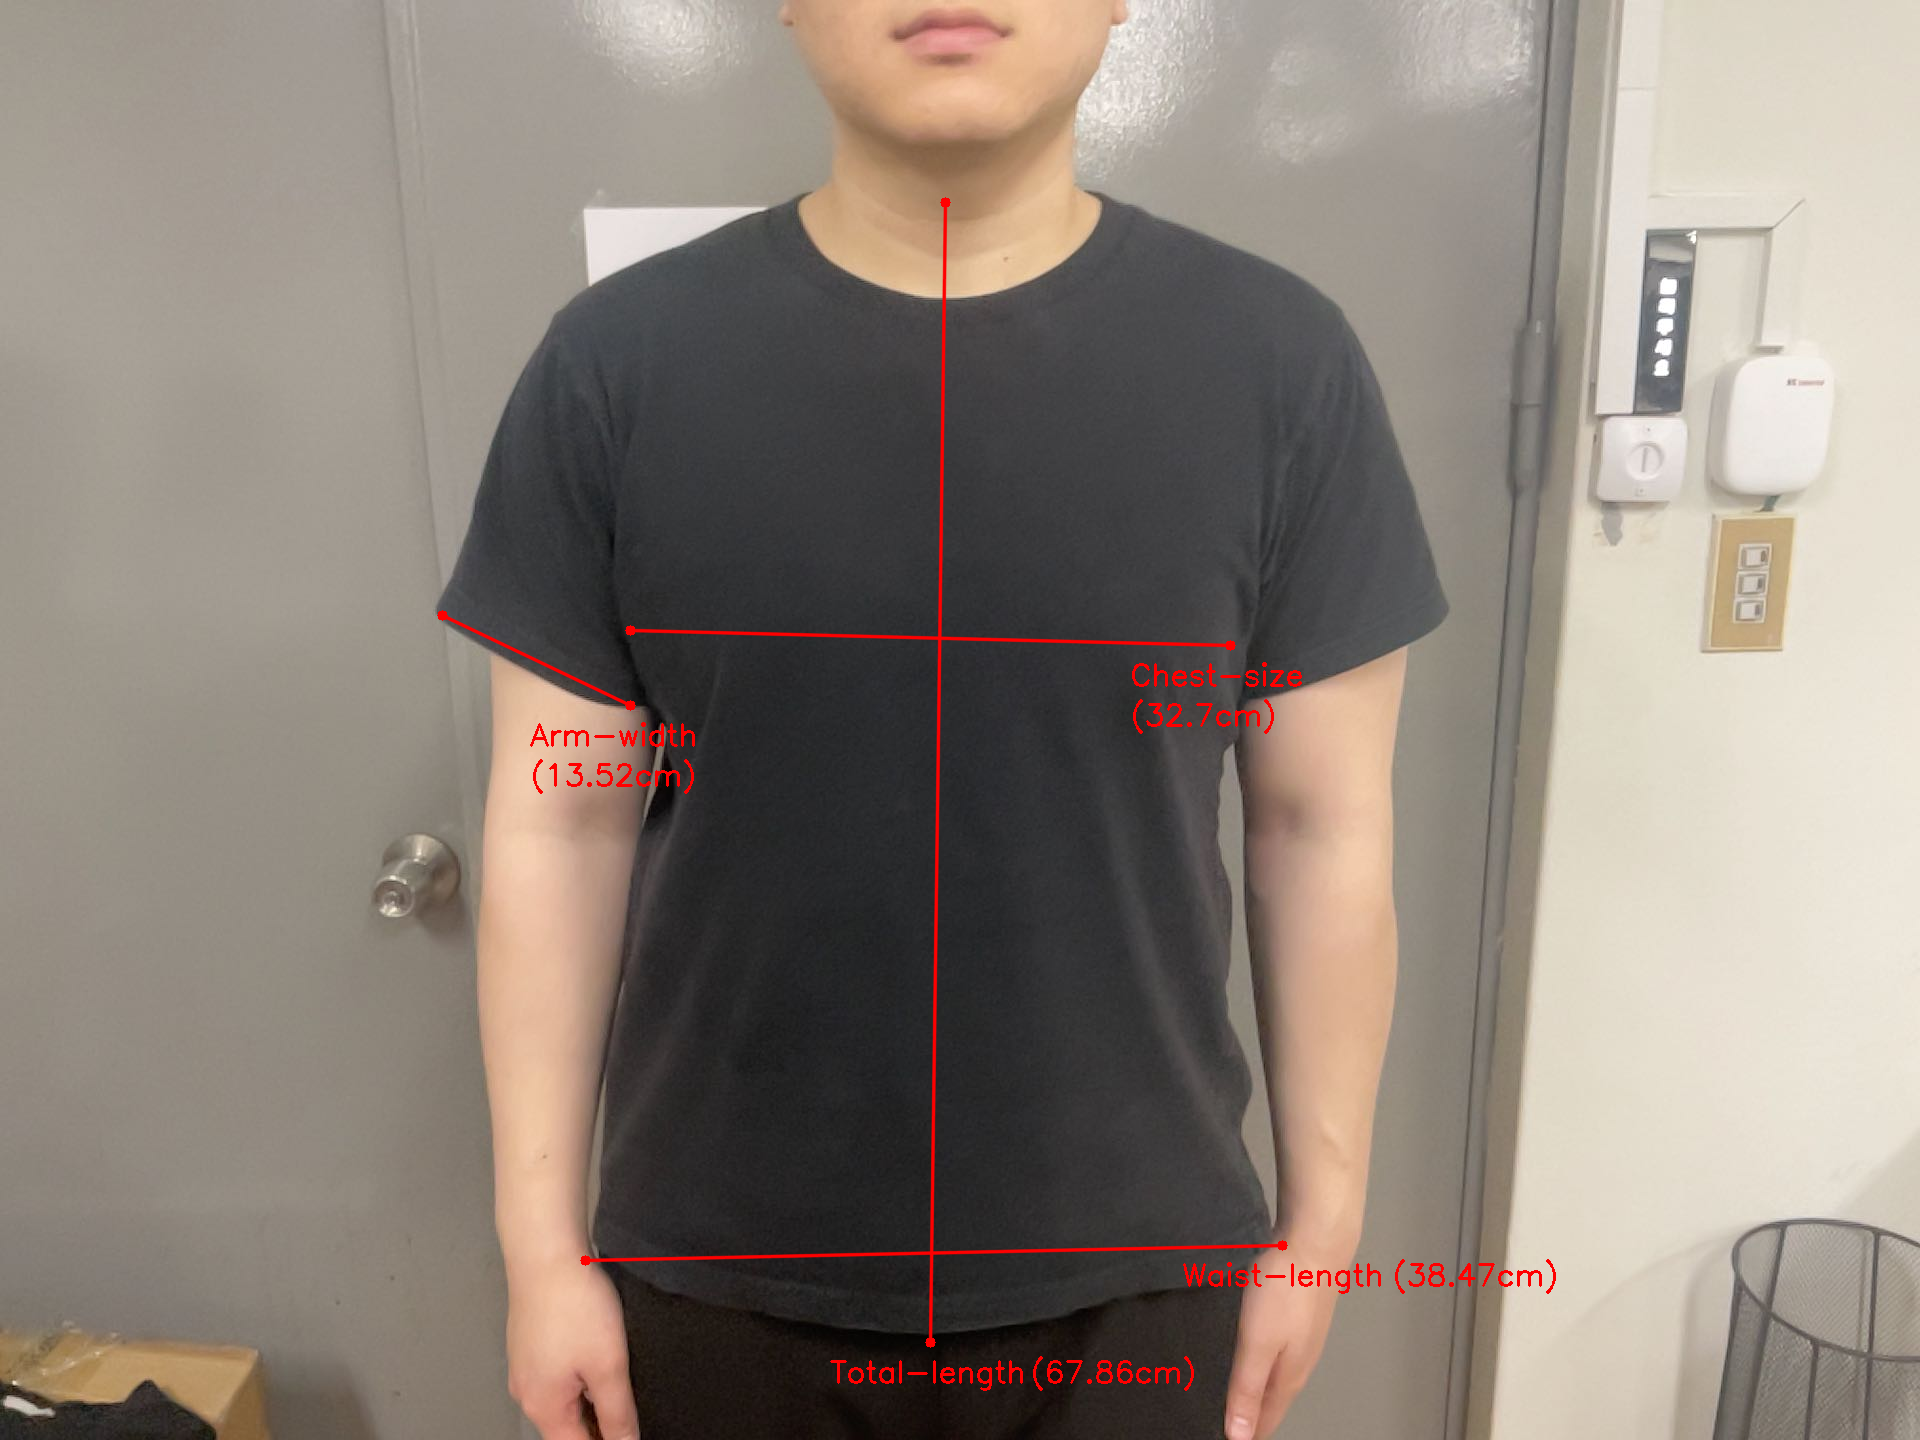

In [66]:
result_img = Image.fromarray(img_arr)
result_img